<a href="https://colab.research.google.com/github/pascale25/Deep_learning/blob/master/mullticlass_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Creating mutli-class classification data

To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's [`make_blobs()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) method.

This method will create however many classes (using the `centers` parameter) we want.

Specifically, let's do the following:

1. Create some multi-class data with `make_blobs()`.
2. Turn the data into tensors (the default of `make_blobs()` is to use NumPy arrays).
3. Split the data into training and test sets using `train_test_split()`.
4. Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


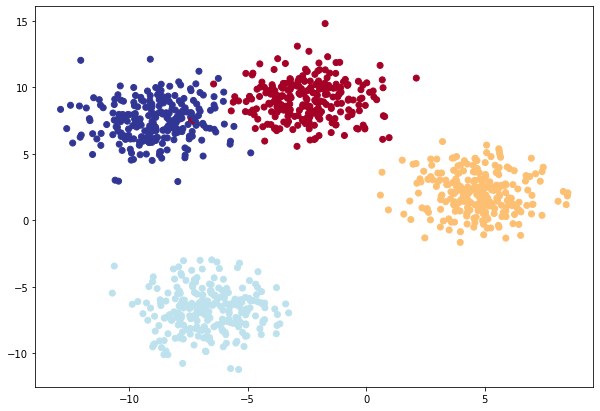

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## Building a multi-class classification model in PyTorch

In [2]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [4]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [5]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-0.4986,  0.1155,  0.6684, -1.3784],
        [ 1.0126,  0.3337, -0.7726,  1.4770],
        [-0.3428,  0.3327,  0.0557,  1.0624],
        [-0.1203,  0.3096, -0.0247,  0.8734],
        [ 0.8420,  0.3332, -0.6673,  1.4202]], grad_fn=<SliceBackward0>)

In [6]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [7]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.3304,  0.1325,  0.5255, -1.1413],
        [ 1.3163,  0.4360, -1.2014,  2.6947],
        [-0.4612,  0.2906,  0.2284,  0.5625],
        [-0.5795,  0.1308,  0.6814, -1.2344],
        [ 0.8091,  0.2822, -0.5258,  0.8485]], grad_fn=<SliceBackward0>)
tensor([[0.1856, 0.2949, 0.4369, 0.0825],
        [0.1830, 0.0759, 0.0148, 0.7263],
        [0.1266, 0.2686, 0.2524, 0.3525],
        [0.1412, 0.2873, 0.4982, 0.0733],
        [0.3456, 0.2040, 0.0910, 0.3594]], grad_fn=<SliceBackward0>)


In [8]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1.0000, grad_fn=<SumBackward0>)

In [9]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1856, 0.2949, 0.4369, 0.0825], grad_fn=<SelectBackward0>)
tensor(2)


In [12]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [13]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.10969, Acc: 28.88% | Test Loss: 0.95372, Test Acc: 71.00%
Epoch: 10 | Loss: 0.13941, Acc: 98.50% | Test Loss: 0.12810, Test Acc: 99.50%
Epoch: 20 | Loss: 0.08005, Acc: 99.25% | Test Loss: 0.07244, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05983, Acc: 99.12% | Test Loss: 0.05251, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04961, Acc: 99.12% | Test Loss: 0.04210, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04355, Acc: 99.12% | Test Loss: 0.03580, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03960, Acc: 99.12% | Test Loss: 0.03161, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03684, Acc: 99.12% | Test Loss: 0.02863, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03481, Acc: 99.25% | Test Loss: 0.02641, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03328, Acc: 99.25% | Test Loss: 0.02470, Test Acc: 99.50%


In [14]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  6.6952,  11.9291,  -9.6244,  -6.5684],
        [  3.7210, -10.6654,   1.8329,   9.2996],
        [-11.9366, -14.9571,  15.5182,   7.0039],
        [  2.5672,   8.3886,  -5.0366,  -5.3703],
        [ 10.8806,   5.7851, -10.3173,  -0.4965],
        [  4.0353, -13.4723,   2.7348,  11.5114],
        [-11.9398, -11.8559,  14.2594,   4.6813],
        [  8.7137,   1.3849,  -6.8752,   2.0351],
        [-12.8703, -20.3043,  18.4050,  10.6784],
        [  9.3227,   2.9573,  -7.9792,   1.0722]])

In [15]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


In [18]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


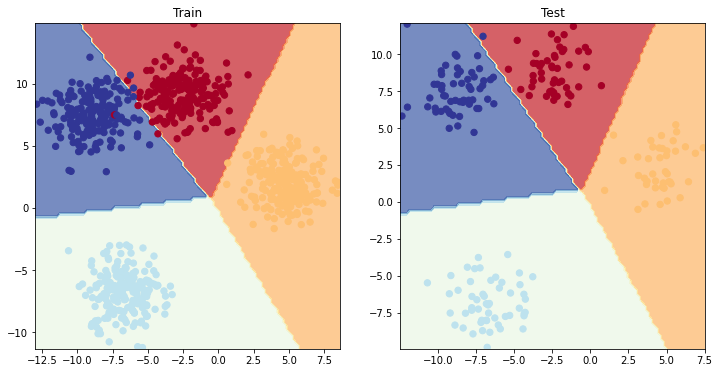

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [20]:
!pip -q install torchmetrics

from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy().to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

     |████████████████████████████████| 529 kB 5.1 MB/s 


tensor(0.9950)